# Model Training

## Importing

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from model.models import Model_1
from testing import test_model, pred_patches
from dataloader import DataLoader
from model.losses import FocalLoss, WBCE
from model.callbacks import UpdateAccuracy
from ops import reconstruct_image
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score

## Parameters

In [4]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [5]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])
full_path = params_patches['full_path']


## Setting Dataloaders

In [6]:
dl_train = DataLoader(
    batch_size = params_training['batch_size'],
    data_path=os.path.join(train_path, params_patches['data_sub']),
    label_path=os.path.join(train_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    shuffle=True, 
    limit=params_training['patch_limit']
)

dl_val = DataLoader(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(val_path, params_patches['data_sub']),
    label_path=os.path.join(val_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    limit=params_training['patch_limit']
)

## Model definition

In [7]:
model = Model_1(name='modelo_1')

metrics = {
}

weights = [0.2, 0.8, 0.0]

learning_rate = InverseTimeDecay(
    initial_learning_rate=1e-4, 
    decay_steps=params_training['learning_reduction']*len(dl_train),
    decay_rate = 0.01,
    staircase=True
    )

optimizers = {
    'opt': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'sar': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'fusion': tf.keras.optimizers.Adam(learning_rate = learning_rate),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = WBCE,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience = params_training['patience'],
        mode = 'min',
        restore_best_weights=True),
    UpdateAccuracy()
]


history = model.fit(
    x=dl_train,
    validation_data=dl_val,
    epochs=params_training['epochs_train'],
    callbacks=callbacks,
    verbose = 1
    )

Epoch 1/50
25/25 [==============================] - 10s 408ms/step - opt_loss: 0.6832 - sar_loss: 0.7044 - fusion_loss: 0.8303 - loss: 2.2179 - opt_accuracy: 0.6229 - sar_accuracy: 0.6517 - fusion_accuracy: 0.5982 - combined_accuracy: 0.6502 - opt_f1score: 0.2619 - sar_f1score: 0.2996 - fusion_f1score: 0.3536 - combined_f1score: 0.3528 - val_opt_loss: 0.4957 - val_sar_loss: 0.4996 - val_fusion_loss: 0.4867 - val_loss: 1.4820 - val_opt_accuracy: 0.6667 - val_sar_accuracy: 0.6667 - val_fusion_accuracy: 0.6669 - val_combined_accuracy: 0.6667 - val_opt_f1score: 0.0037 - val_sar_f1score: 0.0408 - val_fusion_f1score: 0.3754 - val_combined_f1score: 0.3785
Epoch 2/50
25/25 [==============================] - 10s 384ms/step - opt_loss: 0.5840 - sar_loss: 0.6063 - fusion_loss: 0.7316 - loss: 1.9219 - opt_accuracy: 0.6427 - sar_accuracy: 0.6699 - fusion_accuracy: 0.5696 - combined_accuracy: 0.6508 - opt_f1score: 0.2112 - sar_f1score: 0.2756 - fusion_f1score: 0.3092 - combined_f1score: 0.3217 - val

## Show training history

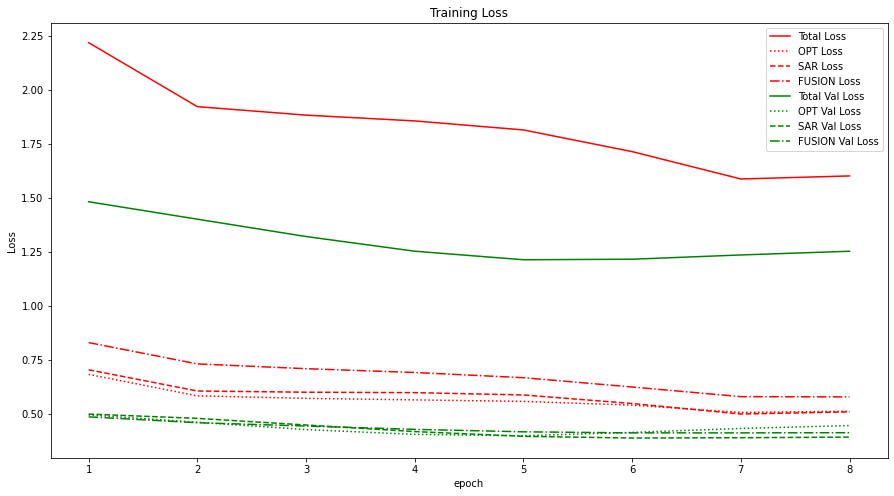

In [9]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['loss'], 'r-',label='Total Loss')
plt.plot(x, history.history['opt_loss'], 'r:',label='OPT Loss')
plt.plot(x, history.history['sar_loss'], 'r--',label='SAR Loss')
plt.plot(x, history.history['fusion_loss'], 'r-.',label='FUSION Loss')

plt.plot(x, history.history['val_loss'], 'g-',label='Total Val Loss')
plt.plot(x, history.history['val_opt_loss'], 'g:',label='OPT Val Loss')
plt.plot(x, history.history['val_sar_loss'], 'g--',label='SAR Val Loss')
plt.plot(x, history.history['val_fusion_loss'], 'g-.',label='FUSION Val Loss')

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('graphics/Loss.png')
plt.show()

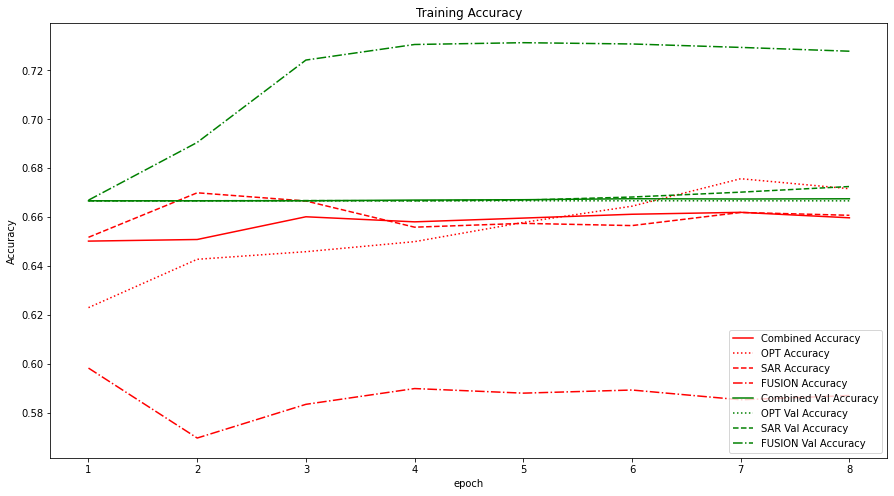

In [10]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_accuracy'], 'r-',label='Combined Accuracy')
plt.plot(x, history.history['opt_accuracy'], 'r:',label='OPT Accuracy')
plt.plot(x, history.history['sar_accuracy'], 'r--',label='SAR Accuracy')
plt.plot(x, history.history['fusion_accuracy'], 'r-.',label='FUSION Accuracy')

plt.plot(x, history.history['val_combined_accuracy'], 'g-',label='Combined Val Accuracy')
plt.plot(x, history.history['val_opt_accuracy'], 'g:',label='OPT Val Accuracy')
plt.plot(x, history.history['val_sar_accuracy'], 'g--',label='SAR Val Accuracy')
plt.plot(x, history.history['val_fusion_accuracy'], 'g-.',label='FUSION Val Accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/Accuracy.png')
plt.show()

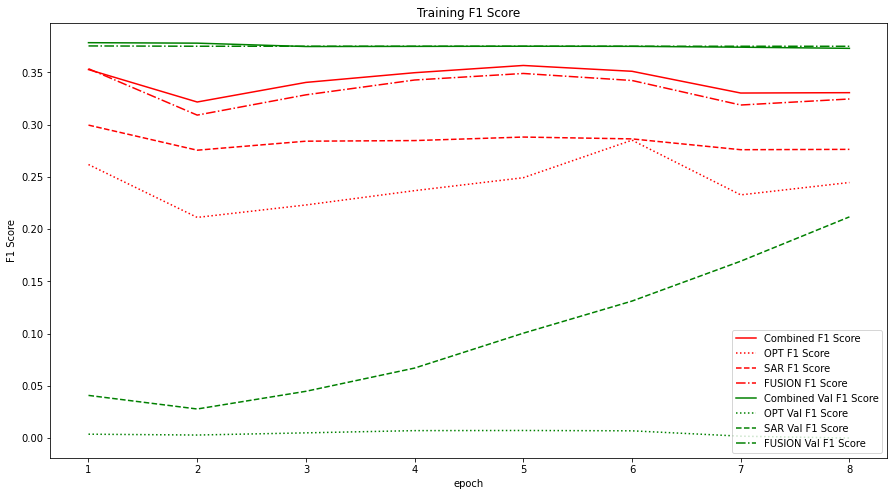

In [11]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_f1score'], 'r-',label='Combined F1 Score')
plt.plot(x, history.history['opt_f1score'], 'r:',label='OPT F1 Score')
plt.plot(x, history.history['sar_f1score'], 'r--',label='SAR F1 Score')
plt.plot(x, history.history['fusion_f1score'], 'r-.',label='FUSION F1 Score')

plt.plot(x, history.history['val_combined_f1score'], 'g-',label='Combined Val F1 Score')
plt.plot(x, history.history['val_opt_f1score'], 'g:',label='OPT Val F1 Score')
plt.plot(x, history.history['val_sar_f1score'], 'g--',label='SAR Val F1 Score')
plt.plot(x, history.history['val_fusion_f1score'], 'g-.',label='FUSION Val F1 Score')

plt.title('Training F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/F1score.png')
plt.show()

In [12]:
model.save_weights('weights.h5')